<a href="https://colab.research.google.com/github/MarioSigal/Elementos-de-Reconocimiento-Visual/blob/main/Laboratorios/Laboratorio2_Descriptores_de_Fourier_Contornos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Nombre de Grupos*:

*Integrantes*:

# **Laboratorio 2: Descriptores de Fourier de Contornos (DFC)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.draw import disk, rectangle
from skimage.measure import find_contours
from skimage.transform import rotate, rescale
from skimage.feature import canny
from skimage.util import img_as_ubyte
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Los Descriptores de Fourier de Contornos (DFC) son un método para representar la forma de un objeto. Se basan en modelar el contorno en una secuencia periódica de coordenadas z=x+iy, y luego tratarla como una señal compleja para aplicar la Transformada Discreta de Fourier (DFT).

Los coeficientes de Fourier resultantes (DFCs) son excelentes features porque, al ser normalizados por su magnitud, se vuelven invariantes a la traslación, escalado y rotación de la forma.

### **Generar el Descriptor**

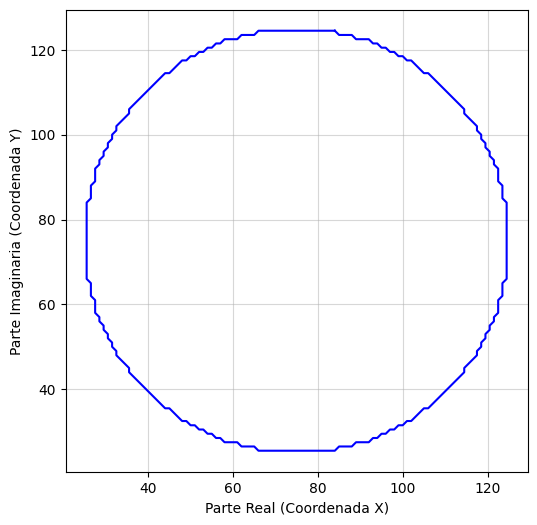

In [ ]:
def plot_secuencia_contorno(image):
  """
  Extrae el contorno y lo grafica en el plano complejo.
  La parte Real corresponde a la coordenada X, la parte Imaginaria a la coordenada Y.
  """
  # Extraemos el contorno
  contours = find_contours(image, level=0.5)

  if not contours:
    print("No se encontró ningún contorno en la imagen.")
    return

  # Seleccionamos el contorno más largo
  contour = max(contours, key=len)

  # Crear la secuencia compleja z = x + iy
  # x = columna (Parte Real)
  # y = fila (Parte Imaginaria)
  x = contour[:, 1]
  y = contour[:, 0]
  complex_contour = x + 1j * y

  # Mostamos la secuencia que sera igual al contorno

  # La parte Real (eje x) es np.real(complex_contour)
  # La parte Imaginaria (eje y) es np.imag(complex_contour)

  plt.figure(figsize=(6, 6))
  plt.plot(np.real(complex_contour), np.imag(complex_contour), 'b-')

  # Etiquetar ejes
  plt.xlabel('Parte Real (Coordenada X)')
  plt.ylabel('Parte Imaginaria (Coordenada Y)')
  plt.gca().set_aspect('equal', adjustable='box') # Mantiene la proporción 1:1
  plt.grid(True, alpha=0.5)
  plt.show()

# Creamos una imagen binaria simple (un disco)
img_size = 150
test_img = np.zeros((img_size, img_size), dtype=np.uint8)
rr, cc = disk((75, 75), 50, shape=test_img.shape)
test_img[rr, cc] = 1

# Visualizamos la secuencia del contorno
plot_secuencia_contorno(test_img)

In [ ]:
def get_fourier_descriptors(image, num_descriptors=30):
    """
    Calcula los Descriptores de Fourier de Contornos (DFC) a partir de una imagen binaria,
    asegurando la invariancia a traslación, escala y rotación.
    """
    # Extraer contorno
    contours = find_contours(image, level=0.5)

    if not contours:
        return np.array([0.0] * num_descriptors)

    # Seleccionamos el contorno más largo
    contour = max(contours, key=len)

    x = contour[:, 1]
    y = contour[:, 0]
    complex_contour = x + 1j * y

    F = np.fft.fft(complex_contour)

    # normalizamos
    F[0] = 0
    F = F / np.abs(F[1])
    F = np.abs(F)

    # truncamos a K descriptores
    K = min(num_descriptors, len(F) - 1)
    F = F[1:K+1]


    # if N < 2 or np.abs(fourier_coeffs[1]) == 0:
        # return np.array([0.0] * num_descriptors)


    return F

## **Demostración de Invarianza a Rotación y Escala**

Comprobamos que las versiones transformadas de una misma forma arrojan descriptores casi idénticos.



### **Generación de Formas Transformadas**

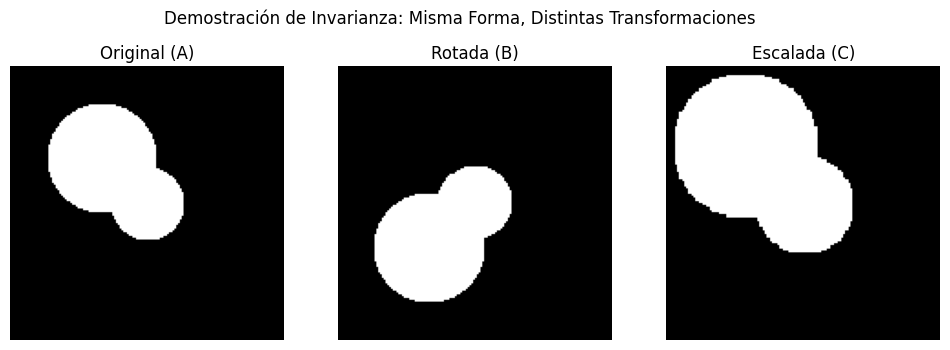

In [ ]:
# Generación de la forma base (una figura compuesta con dos discos)

img_size = 150
base_img = np.zeros((img_size, img_size), dtype=np.uint8)
rr, cc = disk((50, 50), 30, shape=base_img.shape)
base_img[rr, cc] = 255
rr2, cc2 = disk((75, 75), 20, shape=base_img.shape)
base_img[rr2, cc2] = 255

# Versión A: Original
img_A = base_img

# # Versión B: Rotada
img_B = rotate(base_img, angle=90)
img_B[img_B != 0] = 255
img_B = (img_B).astype(np.uint8)

# # Versión C: Escalada
img_C = rescale(base_img, scale=1.3, anti_aliasing=True)
pad_x = (img_C.shape[0] - img_size) // 2
img_C = img_C[pad_x:pad_x+img_size, pad_x:pad_x+img_size]
img_C[img_C != 0] = 255
img_C = (img_C).astype(np.uint8)

# Visualización
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img_A, cmap='gray'); axs[0].set_title('Original (A)'); axs[0].axis('off')
axs[1].imshow(img_B, cmap='gray'); axs[1].set_title('Rotada (B)'); axs[1].axis('off')
axs[2].imshow(img_C, cmap='gray'); axs[2].set_title('Escalada (C)'); axs[2].axis('off')
plt.suptitle('Demostración de Invarianza: Misma Forma, Distintas Transformaciones')
plt.show()

### **Extracción y Comparación de DFCs**

Distancia DFC (Original vs Rotada): 0.0052
Distancia DFC (Original vs Escalada): 0.0039


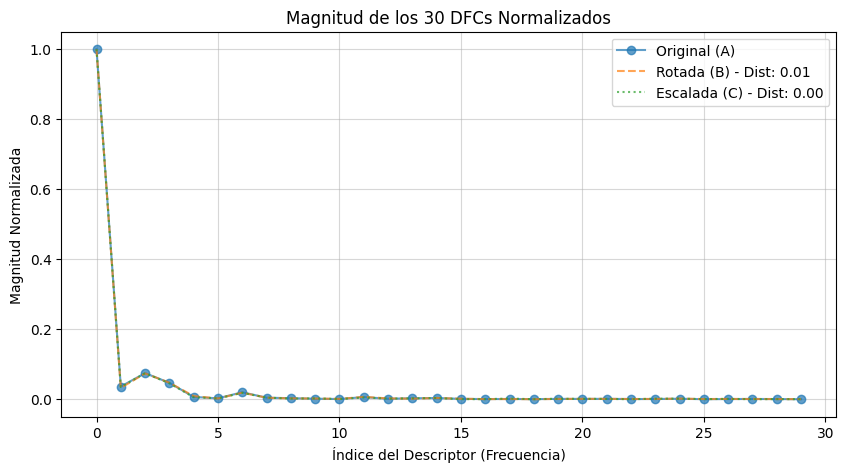

In [ ]:
K = 30 # Número de descriptores a usar para la comparación
dfc_A = get_fourier_descriptors(img_A, K)
dfc_B = get_fourier_descriptors(img_B, K)
dfc_C = get_fourier_descriptors(img_C, K)

# Calcular las distancias Euclidianas
dist_AB = np.linalg.norm(dfc_A - dfc_B)
dist_AC = np.linalg.norm(dfc_A - dfc_C)

print(f"Distancia DFC (Original vs Rotada): {dist_AB:.4f}")
print(f"Distancia DFC (Original vs Escalada): {dist_AC:.4f}")

# Visualización
plt.figure(figsize=(10, 5))
plt.plot(dfc_A, label='Original (A)', linestyle='-', marker='o', alpha=0.7)
plt.plot(dfc_B, label=f'Rotada (B) - Dist: {dist_AB:.2f}', linestyle='--', alpha=0.7)
plt.plot(dfc_C, label=f'Escalada (C) - Dist: {dist_AC:.2f}', linestyle=':', alpha=0.7)
plt.title(f'Magnitud de los {K} DFCs Normalizados')
plt.xlabel('Índice del Descriptor (Frecuencia)')
plt.ylabel('Magnitud Normalizada')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

## **Reconstrucción del Contorno (Análisis de Detalle)**



Usamos la IDFT con un número truncado de coeficientes para demostrar la relación entre los DFCs y el detalle de la forma.

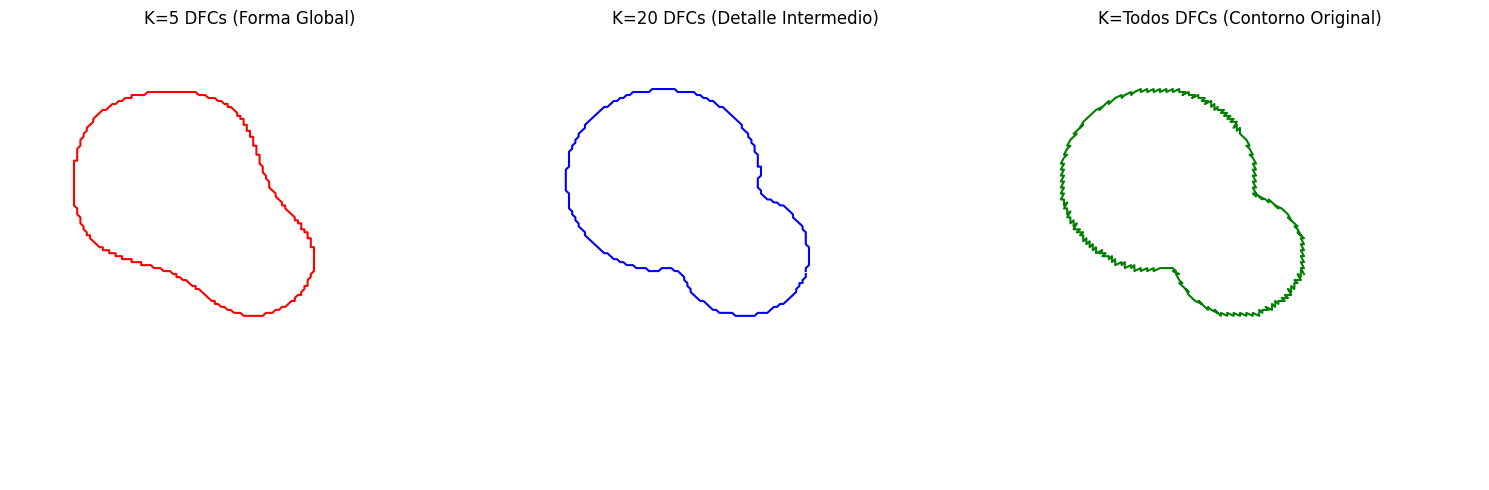

In [ ]:
def reconstruct_contour(contour_points, K_coeffs):
    """Reconstruye el contorno usando solo K_coeffs de la FFT."""

    # Creamos el descriptor de una silueta
    x = contour_points[:, 1]
    y = contour_points[:, 0]
    complex_contour = x + 1j * y
    N = len(complex_contour)

    fourier_coeffs = np.fft.fft(complex_contour)

    # truncamos el descriptor
    truncated_coeffs = np.zeros(N, dtype=np.complex128)

    # Conservar F[0] (traslación) y K de cada lado
    truncated_coeffs[0] = fourier_coeffs[0]
    truncated_coeffs[1:K_coeffs + 1] = fourier_coeffs[1:K_coeffs + 1]
    truncated_coeffs[N - K_coeffs:] = fourier_coeffs[N - K_coeffs:]

    # Transformada Inversa
    reconstructed_contour_complex = np.fft.ifft(truncated_coeffs)

    reconstructed_y = np.real(reconstructed_contour_complex).astype(np.int32)
    reconstructed_x = np.imag(reconstructed_contour_complex).astype(np.int32)

    return np.column_stack((reconstructed_y, reconstructed_x))

# Extraer el contorno base (A)
contour_pts = find_contours(img_A, level=0.5)
contour_pts= contour_pts[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# K=5: Forma Global
K1 = 5
rec_k1 = reconstruct_contour(contour_pts, K1)
axs[0].plot(rec_k1[:, 1], rec_k1[:, 0], 'r-')
axs[0].set_title(f'K={K1} DFCs (Forma Global)')
axs[0].set_ylim(0, img_size); axs[0].set_xlim(0, img_size); axs[0].invert_yaxis()
axs[0].axis('off')

# K=20: Detalle Intermedio
K2 = 20
rec_k2 = reconstruct_contour(contour_pts, K2)
axs[1].plot(rec_k2[:, 1], rec_k2[:, 0], 'b-')
axs[1].set_title(f'K={K2} DFCs (Detalle Intermedio)')
axs[1].set_ylim(0, img_size); axs[1].set_xlim(0, img_size); axs[1].invert_yaxis()
axs[1].axis('off')

# K=Todos: Contorno Original
K3 = len(contour_pts) // 2 - 1
rec_k3 = reconstruct_contour(contour_pts, K3)
axs[2].plot(rec_k3[:, 1], rec_k3[:, 0], 'g-')
axs[2].set_title('K=Todos DFCs (Contorno Original)')
axs[2].set_ylim(0, img_size); axs[2].set_xlim(0, img_size); axs[2].invert_yaxis()
axs[2].axis('off')

plt.tight_layout()
plt.show()

## **Clasificación con Dataset Sintético (Círculo vs. Cuadrado)**



Usamos los DFCs truncados como features de entrada para un clasificador K-Vecinos Cercanos (KNN).



### **Creación del Dataset Sintético**

In [ ]:
def create_shape_image(shape_type, size, scale_factor=1.0, rotation_angle=0):
    """Genera una imagen binaria de una forma con escala y rotación."""
    img = np.zeros((size, size), dtype=np.uint8)
    center = size // 2
    if shape_type == 'circle':
        radius = int(25 * scale_factor)
        rr, cc = disk((center, center), radius, shape=img.shape)
        img[rr, cc] = 255
    elif shape_type == 'square':
        side = int(40 * scale_factor)
        r_min, r_max = center - side // 2, center + side // 2
        rr, cc = rectangle((r_min, r_min), extent=(side, side), shape=img.shape)
        img[rr, cc] = 255

    if rotation_angle != 0:
        img = rotate(img, angle=rotation_angle, resize=False)
        img = ((img > 0.5)*255).astype(np.uint8)

    return img

### **Extraccion de los Features**

In [ ]:
shapes = ['circle', 'square']
n_samples_per_shape = 10
image_size = 100
K_features_synth = 50 # Número de DFC a usar

X_synth = [] # Features (vectores DFC)
y_synth = [] # Labels
imgs = []

for i, shape in enumerate(shapes):
    for j in range(n_samples_per_shape):
        # Generar variaciones aleatorias
        scale = 0.8 + 0.4 * np.random.rand()
        rotation = np.random.randint(0, 360)

        img = create_shape_image(shape, image_size, scale_factor=scale, rotation_angle=rotation)

        # Extracción de Features (DFC)
        dfc_vector = get_fourier_descriptors(img, K_features_synth)
        X_synth.append(dfc_vector)
        imgs.append(img)
        y_synth.append(i) # 0 para círculo, 1 para cuadrado

X_synth = np.array(X_synth)
y_synth = np.array(y_synth)
imgs = np.array(imgs)

print(f"Dataset Sintético Creado. Total de muestras: {len(X_synth)}. Dimensión DFC: {X_synth.shape[1]}")

Dataset Sintético Creado. Total de muestras: 20. Dimensión DFC: 50


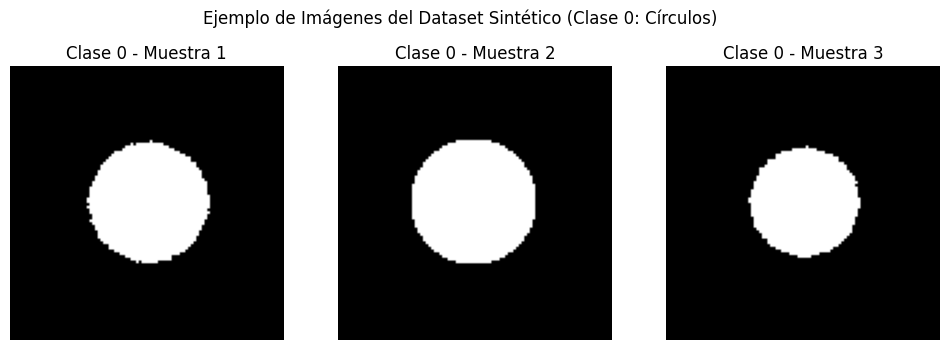

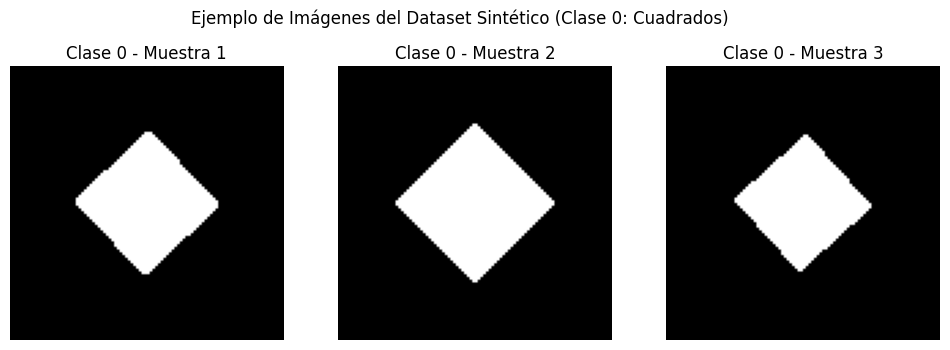

In [ ]:
# Visualización
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Iteramos sobre las primeras 3 imágenes de la clase 0
# Usamos 'enumerate' para obtener el índice (idx) y la imagen (img)
for idx, img in enumerate(imgs[y_synth == 0][:3]):

  # Verificación de seguridad para evitar IndexError si la lista es corta
  if idx < 3:
    axs[idx].imshow(img, cmap='gray')
    axs[idx].set_title(f'Clase 0 - Muestra {idx+1}')
    axs[idx].axis('off')

plt.suptitle('Ejemplo de Imágenes del Dataset Sintético (Clase 0: Círculos)')
plt.show()

# Visualización
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Iteramos sobre las primeras 3 imágenes de la clase 0
# Usamos 'enumerate' para obtener el índice (idx) y la imagen (img)
for idx, img in enumerate(imgs[y_synth == 1][:3]):

  # Verificación de seguridad para evitar IndexError si la lista es corta
  if idx < 3:
    axs[idx].imshow(img, cmap='gray')
    axs[idx].set_title(f'Clase 0 - Muestra {idx+1}')
    axs[idx].axis('off')

plt.suptitle('Ejemplo de Imágenes del Dataset Sintético (Clase 0: Cuadrados)')
plt.show()

### **Clasificación con KNN**

In [ ]:
# Dividir el dataset sintético
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_synth, y_synth, test_size=0.3, random_state=42
)

# Entrenar el clasificador
knn_synth = KNeighborsClassifier(n_neighbors=3)
knn_synth.fit(X_train_s, y_train_s)

# Predecir y evaluar
y_pred_s = knn_synth.predict(X_test_s)
accuracy_s = accuracy_score(y_test_s, y_pred_s)

print("-" * 50)
print("RESULTADOS EN DATASET SINTÉTICO")
print(f"Precisión (Accuracy) del clasificador KNN (K={K_features_synth} DFCs): {accuracy_s * 100:.2f}%")
print("La alta precisión confirma la utilidad de los DFCs para la discriminación de formas.")
print("-" * 50)

--------------------------------------------------
RESULTADOS EN DATASET SINTÉTICO
Precisión (Accuracy) del clasificador KNN (K=50 DFCs): 100.00%
La alta precisión confirma la utilidad de los DFCs para la discriminación de formas.
--------------------------------------------------
